In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [41]:
train_data = pd.read_csv("/kaggle/input/cs-480-2024-spring/data/train.csv")
test_data = pd.read_csv("/kaggle/input/cs-480-2024-spring/data/test.csv")

In [42]:
from sklearn.model_selection import train_test_split

train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)

X_train = train_data.iloc[:, 1:164]
y_train = train_data.iloc[:, 164:]
image_ids_train = train_data.iloc[:, 0]

X_valid = valid_data.iloc[:, 1:164]
y_valid = valid_data.iloc[:, 164:]
image_ids_valid = valid_data.iloc[:, 0]

X_test = test_data.iloc[:, 1:164]
image_ids_test = test_data.iloc[:, 0]

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
y_train = scaler.fit_transform(y_train)
y_valid = scaler.fit_transform(y_valid)
X_test = scaler.transform(X_test)

In [71]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class PlantDataset(Dataset):
    def __init__(self, x, y, image_ids, transform=None):
        self.x = x
        self.y = y
        self.image_ids = image_ids.values
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = f'/kaggle/input/cs-480-2024-spring/data/train_images/{img_id}.jpeg'
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        ancillary_data = torch.tensor(self.x[idx], dtype=torch.float32)
        label = torch.tensor(self.y[idx], dtype=torch.float32)

        return image, ancillary_data, label

In [72]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = PlantDataset(x=X_train, y=y_train, image_ids=image_ids_train, transform=transform)
valid_dataset = PlantDataset(x=X_valid, y=y_valid, image_ids=image_ids_valid, transform=transform)

In [73]:
import torch.nn as nn

class PlantModel(nn.Module):
    def __init__(self, base_model):
        super(PlantModel, self).__init__()
        self.base_model = base_model
        self.fc_ancillary = nn.Linear(163, 512)
        self.fc_combined = nn.Linear(384 + 512, 6)
    
    def forward(self, x, ancillary_data):
        x = self.base_model(x)
        
        ancillary_out = torch.relu(self.fc_ancillary(ancillary_data))
        x = x.flatten(start_dim=1)
        
        combined = torch.cat((x, ancillary_out), dim=1)
        
        out = self.fc_combined(combined)
        return out

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)
model = PlantModel(base_model=dino_model)
model.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


PlantModel(
  (base_model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): Lay

In [76]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses = []
valid_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for image, ancillary_data, labels in train_loader:
        image, ancillary_data, labels = image.to(device), ancillary_data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(image, ancillary_data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader)}")
    
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for image, ancillary_data, labels in valid_loader:
            image, ancillary_data, labels = image.to(device), ancillary_data.to(device), labels.to(device)
            output = model(image, ancillary_data)
            loss = criterion(output, labels)
            running_loss += loss.item()
        valid_losses.append(running_loss / len(valid_loader))
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {running_loss / len(valid_loader)}")

Epoch [1/10], Training Loss: 0.917497813298733
Epoch [1/10], Validation Loss: 0.8728336724832675
Epoch [2/10], Training Loss: 0.86550773549462
Epoch [2/10], Validation Loss: 0.8710953779260977
Epoch [3/10], Training Loss: 0.8554083114863816
Epoch [3/10], Validation Loss: 0.8605744087610887
Epoch [4/10], Training Loss: 0.8488131184412248
Epoch [4/10], Validation Loss: 0.8575227430623596
Epoch [5/10], Training Loss: 0.844500075727203
Epoch [5/10], Validation Loss: 0.8556624965844423
Epoch [6/10], Training Loss: 0.8414171886579135
Epoch [6/10], Validation Loss: 0.851072658037139
Epoch [7/10], Training Loss: 0.8384424169731156
Epoch [7/10], Validation Loss: 0.8549413638161096
Epoch [8/10], Training Loss: 0.8362900090414486
Epoch [8/10], Validation Loss: 0.8520700205418029
Epoch [9/10], Training Loss: 0.8339526790274643
Epoch [9/10], Validation Loss: 0.8473277450425386
Epoch [10/10], Training Loss: 0.8331111780487308
Epoch [10/10], Validation Loss: 0.8547636283267034


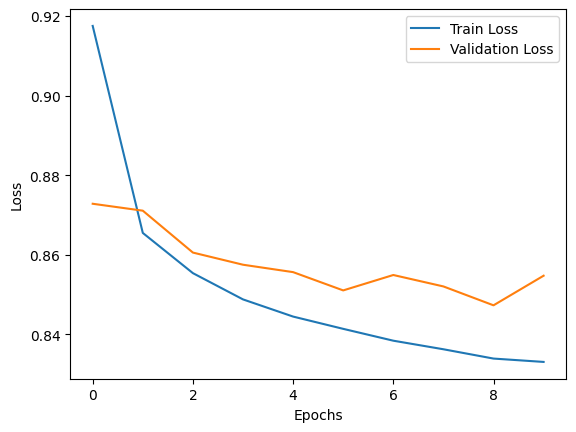

In [78]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
class PlantTestDataset(Dataset):
    def __init__(self, x, image_ids, transform=None):
        self.x = x
        self.image_ids = image_ids.values
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = f'/kaggle/input/cs-480-2024-spring/data/test_images/{img_id}.jpeg'
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        ancillary_data = torch.tensor(self.x[idx], dtype=torch.float32)

        return image, ancillary_data

In [85]:
test_dataset = PlantTestDataset(x=X_test, image_ids=image_ids_test, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

model.eval()
predictions = []

with torch.no_grad():
    for images, ancillary_data in test_loader:
        images, ancillary_data = images.to(device), ancillary_data.to(device)
        outputs = model(images, ancillary_data)
        predictions.append(outputs.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)

In [88]:
rescaled = scaler.inverse_transform(predictions)

submission = pd.DataFrame(rescaled, columns=['X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
submission.insert(0, 'id', test_data['id'])

submission.to_csv('submission.csv', index=False)